STAT 154 FINAL PROJECT 

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

import sys
sys.path.append('C:\\Users\\94726\\appdata\\local\\programs\\python\\python38-32\\lib\\site-packages')
from imblearn.combine import SMOTETomek

from sklearn.model_selection import train_test_split

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.tree import DecisionTreeRegressor, DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.feature_extraction.text import CountVectorizer
# import xgboost as xgb

from sklearn.metrics import confusion_matrix
from sklearn.metrics import roc_curve, auc
from sklearn.metrics import accuracy_score
from sklearn.cluster import KMeans
from sklearn.svm import SVC

from bs4 import BeautifulSoup
from string import punctuation
import re
import nltk
nltk.download('punkt')
nltk.download('stopwords')
nltk.download('averaged_perceptron_tagger')
nltk.download('wordnet')
from nltk import pos_tag
from nltk.corpus import wordnet
from nltk.tokenize.toktok import ToktokTokenizer
from nltk.stem import LancasterStemmer,WordNetLemmatizer
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
from nltk.tokenize.treebank import TreebankWordDetokenizer
from sklearn.feature_extraction.text import CountVectorizer

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\94726\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\94726\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     C:\Users\94726\AppData\Roaming\nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\94726\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


# 1. Data Describtion and EDA

## 1.1 Data Describtion

In [2]:
test_as_training = pd.read_csv("job_verification_data.csv")
training = pd.read_csv("job_training_data.csv")
job = pd.concat([training, test_as_training])

In [3]:
job = job.reset_index()
job = job.iloc[:, 1:]

In [4]:
job.head()

,job_id,title,location,department,salary_range,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function.,fraudulent
0,13454,Field Operations Specialist,"US, SD, Yankton",NaN,NaN,"Working at FBNAt FBN, we put farmers first. Fo...",Farmers Business Network (“FBN”) is an advance...,"Things we look forHonesty, integrity and a pas...",Competitive compensation based on experienceHe...,0,1,0,Full-time,Director,Bachelor's Degree,Farming,Customer Service,0
1,11411,CM2 5AS Warehousing apprenticeship available u...,"GB, , Chelmsford",NaN,NaN,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,1,1,NaN,Not Applicable,High School or equivalent,NaN,NaN,0
2,15153,Lead QA Tester,"GB, LND, London",Blippbuilder,35000-40000,"As augmented reality jobs go, one at Blippar i...",We are looking for an experienced Lead QA test...,This role requires somebody who has both a str...,"Our bright, open, centrally located offices ar...",0,1,1,Full-time,Mid-Senior level,Bachelor's Degree,Computer Software,Quality Assurance,0
3,2814,Basingstoke Fragrance/Beauty Staff Needed,"GB, HAM, Basingstoke",NaN,NaN,Established on the principles that full time e...,We are currently recruiting for an exciting Pr...,NaN,NaN,0,1,0,NaN,NaN,NaN,Cosmetics,NaN,0
4,13996,Swim Instructor,"US, NJ, Hawthorne",NaN,NaN,NaN,Looking for a part time swimming instructor to...,Must be Lifeguard and CPR certified,Pay is negotiable,0,0,1,Part-time,NaN,Unspecified,NaN,Other,0


In [5]:
job.shape

(6362, 18)

In [6]:
job.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362 entries, 0 to 6361
Data columns (total 18 columns):
 #   Column               Non-Null Count  Dtype 
---  ------               --------------  ----- 
 0   job_id               6362 non-null   int64 
 1   title                6362 non-null   object
 2   location             6248 non-null   object
 3   department           2255 non-null   object
 4   salary_range         1024 non-null   object
 5   company_profile      5150 non-null   object
 6   description          6361 non-null   object
 7   requirements         5386 non-null   object
 8   benefits             3822 non-null   object
 9   telecommuting        6362 non-null   int64 
 10  has_company_logo     6362 non-null   int64 
 11  has_questions        6362 non-null   int64 
 12  employment_type      5152 non-null   object
 13  required_experience  3870 non-null   object
 14  required_education   3456 non-null   object
 15  industry             4637 non-null   object
 16  functi

In [7]:
len(job[job['fraudulent'] == 1])/len(job)

0.048569632191134866

* The data we are working with in this project is composed of job posts. There are in total 5362 job posts (i.e., 5362 observations) and 18 features of these posts (i.e., 18 variables), including company location, department of the position, salary range, job description, requirement, etc. Our goal is to build an classifier that distinguishs fraudulent job posts from real job posts with the given information.<br>
* There are null values in most of the columns, espectially noticeable in `salary_range`, which only 870 observations are non-null. So in the feature engineering part we are going to drop it directly.<br>
* Also notice that our target, `fraudulent`, is inbalanced: only 4.8% of the data are fraudulent. So in the modeling part we use SMOTE technique to balance it.

## 1.2 EDA

__Fraudulent__

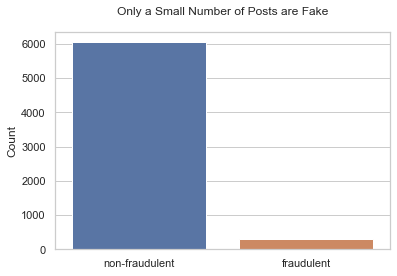

In [8]:
_1 = job.copy()
_1['text_fraudulent'] = _1['fraudulent'].replace({0: 'non-fraudulent', 1: 'fraudulent'})

sns.set_theme(style = 'whitegrid')
sns.countplot(data = _1, x = 'text_fraudulent')
plt.xlabel('')
plt.ylabel('Count')
plt.title('Only a Small Number of Posts are Fake', y = 1.05);

__Employment Types__

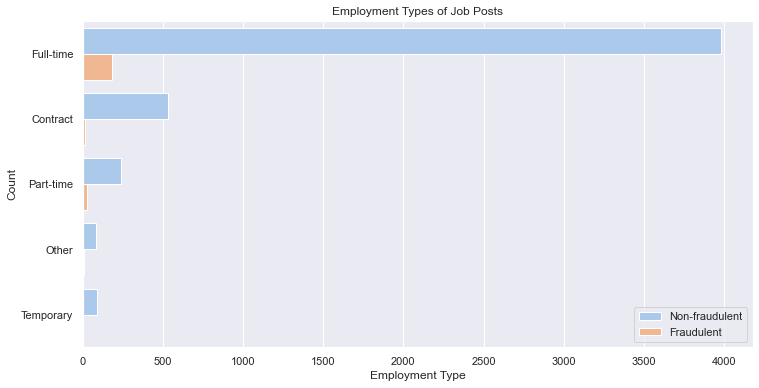

In [9]:
plt.figure(figsize = (12,6))
sns.set_theme(font_scale = 1, palette = 'pastel')
sns.countplot(data = job, y = 'employment_type', 
              hue = 'fraudulent',
              order = job['employment_type'].value_counts().index)
plt.xlabel('Employment Type')
plt.ylabel('Count')
plt.title('Employment Types of Job Posts')
plt.legend(labels = ['Non-fraudulent', 'Fraudulent'], loc='lower right');

__Required Education__

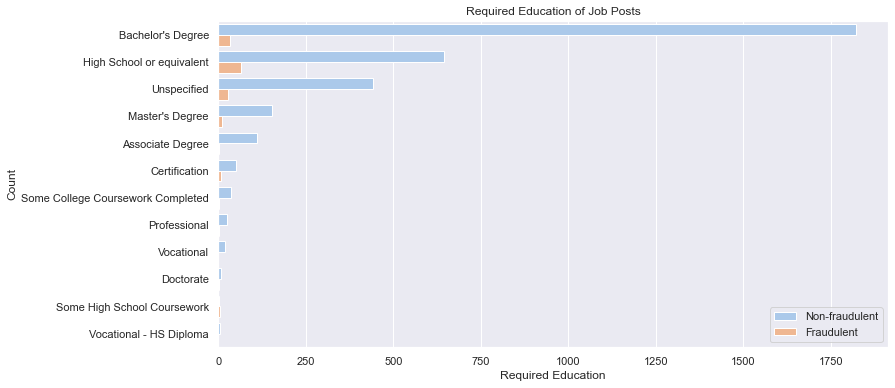

In [10]:
plt.figure(figsize = (12,6))
sns.set_theme(font_scale = 1, palette = 'pastel')
sns.countplot(data = job, y = 'required_education',
              hue = 'fraudulent',
              order = job['required_education'].value_counts().index)
plt.xlabel('Required Education')
plt.ylabel('Count')
plt.title('Required Education of Job Posts')
plt.legend(labels = ['Non-fraudulent', 'Fraudulent'], loc='lower right');

__Correlation of numeric features__

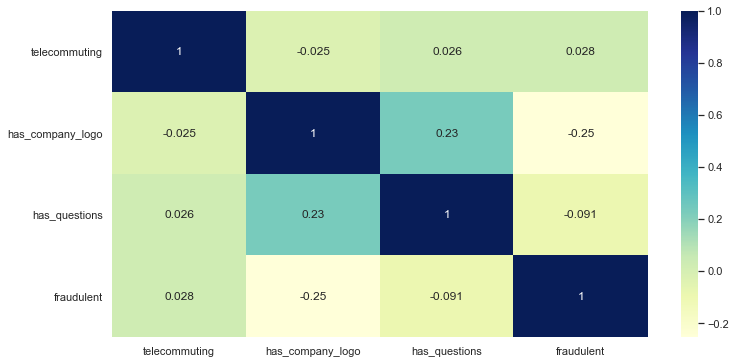

In [11]:
_1 = job.copy()
del _1['job_id']
plt.figure(figsize = (12,6))
sns.heatmap(_1.corr(), cmap="YlGnBu", annot=True);

__Fake post location__

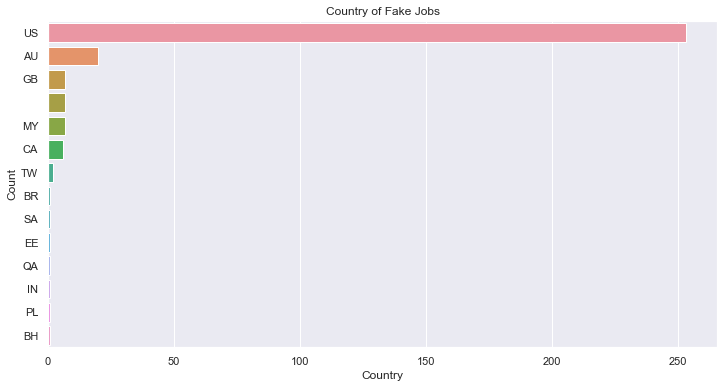

In [12]:
_1 = job.copy()
# get the country of the job
_1['location'] = _1['location'].fillna(' , , ')
country = []
for l in _1['location'].str.split(','):
    country += [l[0]]
_1['country'] = country
# keep only the fraudulent jobs
fake_jobs = _1[_1['fraudulent']==1]

# plot the country of the fraudulent jobs
plt.figure(figsize = (12,6))
sns.set_theme(font_scale = 1, palette = 'pastel')
sns.countplot(data = fake_jobs, y = 'country',
              order = fake_jobs['country'].value_counts().index)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Country of Fake Jobs');

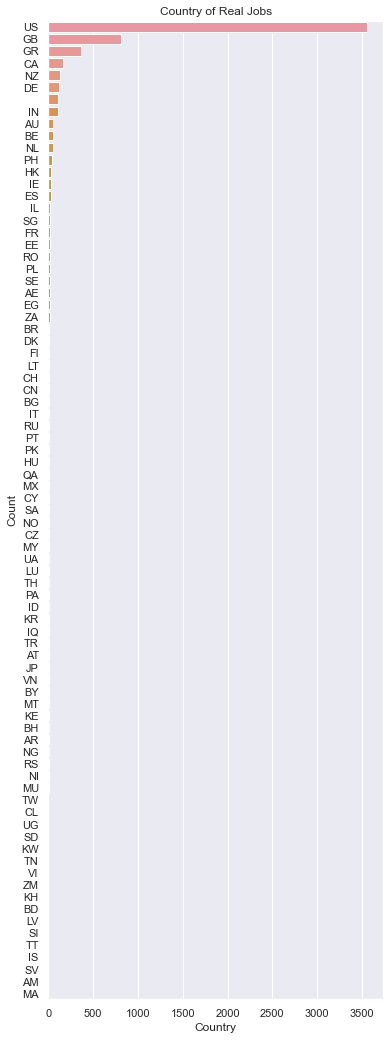

In [13]:
# keep only the real jobs
real_jobs = _1[_1['fraudulent']==0]

# plot the country of the fraudulent jobs
plt.figure(figsize = (6,18))
sns.set_theme(font_scale = 1, palette = 'pastel')
sns.countplot(data = real_jobs, y = 'country',
              order = real_jobs['country'].value_counts().index)
plt.xlabel('Country')
plt.ylabel('Count')
plt.title('Country of Real Jobs');

# 2. Feature Creation

In [14]:
# delete job _id which is useless
# delete salary_range, which has too much Null 
del job['job_id']
del job['salary_range']

In [15]:
# fillna with ''
job = job.replace(np.nan, '', regex=True)
job.head(2)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function.,fraudulent
0,Field Operations Specialist,"US, SD, Yankton",,"Working at FBNAt FBN, we put farmers first. Fo...",Farmers Business Network (“FBN”) is an advance...,"Things we look forHonesty, integrity and a pas...",Competitive compensation based on experienceHe...,0,1,0,Full-time,Director,Bachelor's Degree,Farming,Customer Service,0
1,CM2 5AS Warehousing apprenticeship available u...,"GB, , Chelmsford",,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,1,1,,Not Applicable,High School or equivalent,,,0


## 2.1 Non-text columns

In [16]:
non_text_columns = ['telecommuting', 
                    'has_company_logo', 
                    'has_questions', 
                    'employment_type',
                    'required_experience', 
                    'required_education', 
                    'industry', 
                    'function.']
# three types:
# 1/ `telecommuting`, 'has_company_logo' and 'has_questions' are 0/1, no changes to them
# 2/ `employment_type`, 'required_experience' and `required_eduacation` are ordinary, label
# 3/ `industry` and `function.` are categorical, OHE

### a) No changes to 0/1 columns

### b) Label the ordinary columns

In [17]:
job[job['fraudulent'] == 1]['employment_type'].value_counts()

Full-time    182
              79
Part-time     26
Contract      15
Other          7
Name: employment_type, dtype: int64

In [18]:
job[job['fraudulent'] == 1]['required_experience'].value_counts()

                    157
Entry level          57
Mid-Senior level     38
Not Applicable       30
Associate            15
Executive             6
Director              4
Internship            2
Name: required_experience, dtype: int64

In [19]:
job[job['fraudulent'] == 1]['required_education'].value_counts()

                                     161
High School or equivalent             63
Bachelor's Degree                     34
Unspecified                           26
Master's Degree                        9
Certification                          8
Some High School Coursework            3
Associate Degree                       2
Some College Coursework Completed      1
Doctorate                              1
Professional                           1
Name: required_education, dtype: int64

In [20]:
# replace the text with numeric labels
replacement_dict = {
    'employment_type': {'Full-time':0,'':1,'Part-time':2,'Contract':3,'Other':4,'Temporary':5}, 
    'required_experience': {'':0, 'Not Applicable':1, 'Internship':2, 'Entry level':3, 'Associate':4, 'Mid-Senior level':5, 'Director':6, 'Executive':7},
    'required_education': {'':0, 'Unspecified':1, 'Some High School Coursework':2, 'Vocational':3, 'High School or equivalent': 4, 'Vocational - HS Diploma':5, 'Certification':6, 'Some College Coursework Completed':7, 'Associate Degree':8, "Bachelor's Degree": 9,  "Master's Degree": 10, 'Professional':11, 'Doctorate':12}
}
job.replace(replacement_dict, inplace=True)
# in required_education, all category other than the 5 will be labed 6
job['required_education'].replace(to_replace=r'[^0-9]', value=13, regex=True, inplace=True)

In [21]:
job.head()

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,industry,function.,fraudulent
0,Field Operations Specialist,"US, SD, Yankton",,"Working at FBNAt FBN, we put farmers first. Fo...",Farmers Business Network (“FBN”) is an advance...,"Things we look forHonesty, integrity and a pas...",Competitive compensation based on experienceHe...,0,1,0,0,6,9,Farming,Customer Service,0
1,CM2 5AS Warehousing apprenticeship available u...,"GB, , Chelmsford",,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,1,1,1,1,4,,,0
2,Lead QA Tester,"GB, LND, London",Blippbuilder,"As augmented reality jobs go, one at Blippar i...",We are looking for an experienced Lead QA test...,This role requires somebody who has both a str...,"Our bright, open, centrally located offices ar...",0,1,1,0,5,9,Computer Software,Quality Assurance,0
3,Basingstoke Fragrance/Beauty Staff Needed,"GB, HAM, Basingstoke",,Established on the principles that full time e...,We are currently recruiting for an exciting Pr...,,,0,1,0,1,0,0,Cosmetics,,0
4,Swim Instructor,"US, NJ, Hawthorne",,,Looking for a part time swimming instructor to...,Must be Lifeguard and CPR certified,Pay is negotiable,0,0,1,2,0,1,,Other,0


### c) OHE industry and function

In [22]:
# industry

# get the most common industries
industry = job['industry'].value_counts()
common_industries = industry.index[industry >= 15].to_list() # 50 in total

# OHE them
other = np.zeros(len(job)) 
for industry in common_industries:
    dummy = np.zeros(len(job))
    for i in range(len(job)):
        if job['industry'][i] not in common_industries:
            other[i] = 1
        elif job['industry'][i] == industry:
            dummy[i] = 1    
    job[industry + '_indus'] = dummy
# other than the common industries
job['Others_indus'] = other

# rename the missing column
job = job.rename({'_indus':'missing_indus'}, axis=1)

In [23]:
# #check
# _1 = job.copy()
# _1['indus_sum'] = sum(_1[col] for col in _1.iloc[:, -51:].columns)
# sum(_1['indus_sum'] == 1) == len(job)

In [24]:
# function

# all the functions as the common functions
function = job['function.'].value_counts()
common_functions = function.index.to_list() # 38 in total

# OHE them 
other = np.zeros(len(job)) 
for function in common_functions:
    dummy = np.zeros(len(job))
    for i in range(len(job)):
        if job['function.'][i] not in common_functions:
            other[i] = 1
        elif job['function.'][i] == function:
            dummy[i] = 1    
    job[function+'_func'] = dummy

# other than the common industries
job['Others_func'] = other
# rename the missing column
job = job.rename({'_func':'missing_func'}, axis=1)

In [25]:
# check
#_1 = job.copy()
#_1['func_sum'] = sum(_1[col] for col in _1.iloc[:, -39:].columns)
#sum(_1['func_sum'] == 1) == len(job)

In [26]:
job.drop(["industry"], axis=1, inplace=True)
job.drop(["function."], axis=1, inplace=True)

## 2.2 Text Column

In [27]:
text_columns = ['location',
                'title', 
                'department',
                'company_profile',
                'description',
                'requirements',
                'benefits']

### a) Length of text

In [28]:
# Add columns representing the lenght of the text columns 
for column in text_columns:
    job[column+'_len'] = job[column].str.len()

job.head(2)

,title,location,department,company_profile,description,requirements,benefits,telecommuting,has_company_logo,has_questions,...,Science_func,Purchasing_func,Others_func,location_len,title_len,department_len,company_profile_len,description_len,requirements_len,benefits_len
0,Field Operations Specialist,"US, SD, Yankton",,"Working at FBNAt FBN, we put farmers first. Fo...",Farmers Business Network (“FBN”) is an advance...,"Things we look forHonesty, integrity and a pas...",Competitive compensation based on experienceHe...,0,1,0,...,0.0,0.0,0.0,15,27,0,2559,871,1383,100
1,CM2 5AS Warehousing apprenticeship available u...,"GB, , Chelmsford",,Established on the principles that full time e...,This is fantastic opportunity for someone want...,Government funding is only available for 16-18...,Future Prospects,0,1,1,...,0.0,0.0,0.0,16,76,0,829,391,88,16


### b) All text into one column

In [29]:
# add a text column and drop the redudent columns
job['text'] = job[text_columns].apply(lambda x: ' '.join(x), axis = 1)
job.drop(text_columns, axis=1, inplace=True)

In [30]:
# punctuations
def remove_punct(text):
    table = str.maketrans('','', punctuation)
    return text.translate(table) 
# text process
def text_preprocess(text):
    text = text.replace('\\r', ' ')
    text = text.replace('\\"', ' ')
    text = text.replace('\\n', ' ')
    text = re.sub('[^A-Za-z0-9]+', ' ', str(text))
    # stop words
    stop = set(stopwords.words('english'))
    text = ' '.join(e for e in text.split() if e.lower() not in stop)
    # remove punctuation
    text = remove_punct(text)
    text = text.lower()
    # porter stemmer
    ps = PorterStemmer()
    text = ps.stem(text)
    return text

In [31]:
job['text'] = job['text'].apply(text_preprocess)
job.head(2)

,telecommuting,has_company_logo,has_questions,employment_type,required_experience,required_education,fraudulent,missing_indus,Information Technology and Services_indus,Computer Software_indus,...,Purchasing_func,Others_func,location_len,title_len,department_len,company_profile_len,description_len,requirements_len,benefits_len,text
0,0,1,0,0,6,9,0,0.0,0.0,0.0,...,0.0,0.0,15,27,0,2559,871,1383,100,us sd yankton field operations specialist work...
1,0,1,1,1,1,4,0,1.0,0.0,0.0,...,0.0,0.0,16,76,0,829,391,88,16,gb chelmsford cm2 5as warehousing apprenticesh...


In [32]:
# for power feature creation
job2 = job.copy()
job3 = job.copy()

### c) Vectorize the text

In [33]:
# Making a dictionary of the words and their vector representation

embeddings_index = {}
f = open('glove.42B.300d.txt','r', encoding='UTF-8')
for line in f:
    values = line.split(' ')
    # The first entry is the word
    word = values[0] 
    # vectors embedding the word
    coefs = np.asarray(values[1:], dtype='float32') 
    embeddings_index[word] = coefs
f.close()

In [34]:
# convert words in the text column into vectors
# functions

def convert_sen_to_vec(sentence):
    # each word has the vector length of 300
    vector = np.zeros(300) 
    # num of words with a valid vector in the sentence
    num_words =0; 
    for word in sentence.split():
        if word in embeddings_index.keys():
            vector += embeddings_index[word]
            num_words += 1
    if num_words != 0:
        # the average of vectors in each sentence
        vector /= num_words
    return vector

In [ ]:
# convert words in the text column into vectors
# convertion

converted_text = []

for i in range(0, job.shape[0]):
    converted_text.append(convert_sen_to_vec(job['text'][i]))

text_vectors = pd.DataFrame(converted_text)

## 2.3 Results untill this step

In [ ]:
job.drop(["text"], axis=1, inplace=True)
job.drop(["fraudulent"], axis=1, inplace=True)
words_vectors = pd.concat([text_vectors, job], axis=1)

In [ ]:
words_vectors.head()

In [ ]:
words_vectors.shape

Features in `words_vectors`:<br>
1. Vector representation of text (a total of 300)
2. Unchanged 1/0 numeric columns (a total of 3)
3. Labeled ordinary numeric columns (a total of 3)
4. OHE industry and functions (51 + 39)
5. Length of texts (7)

## 2.4 Most Common Words

In [ ]:
job2.head(2)

In [ ]:
real_job = job2[job2['fraudulent'] == 0].reset_index()
fake_job = job2[job2['fraudulent'] == 1].reset_index()

In [ ]:
real_word_counts = {}
for i in range(len(real_job)):
    for word in real_job['text'][i].split(" "):
        if word in real_word_counts.keys():
            real_word_counts[word] += 1
        else: 
            real_word_counts[word] = 1
# sort
real_word_counts = dict(sorted(real_word_counts.items(), key=lambda item: item[1], reverse=True))
# first 80
real_first_100 = dict(list(real_word_counts.items())[:100])

In [ ]:
plt.figure(figsize = (30, 10))
plt.bar(real_first_100.keys(), real_first_100.values(), color='g')
plt.xticks(rotation = 90)
plt.title("Most Common Words in Real Job Posts");

In [ ]:
fake_word_counts = {}
for i in range(len(fake_job)):
    for word in fake_job['text'][i].split(" "):
        if word in fake_word_counts.keys():
            fake_word_counts[word] += 1
        else: 
            fake_word_counts[word] = 1
# sort
fake_word_counts = dict(sorted(fake_word_counts.items(), key=lambda item: item[1], reverse=True))
# first 100
fake_first_100 = dict(list(fake_word_counts.items())[:100])

In [ ]:
plt.figure(figsize = (20, 10))
plt.bar(fake_first_100.keys(), fake_first_100.values(), color='g')
plt.xticks(rotation = 90)
plt.title("Most Common Words in Fake Job Posts");

In [ ]:
# many words appears a lot in both real and fake posts
# so the words which only appear in one kind are the real important ones
real_words = set(real_first_100.keys())
fake_words = set(fake_first_100.keys())
distinct_real = real_words.difference(fake_words)
distinct_fake = fake_words.difference(real_words)

In [ ]:
# add word counts

# real
for word in distinct_real:
    count = np.zeros(len(job2))
    for i in range(len(job2)):
        count[i] = job2['text'][i].count(word)
    job2[word+'_real'] = count
job2['sum_real'] = sum(job2[col] for col in job2.iloc[:, -len(distinct_real):].columns)

# fake
for word in distinct_fake:
    count = np.zeros(len(job2))
    for i in range(len(job2)):
        count[i] = job2['text'][i].count(word)
    job2[word+'_fake'] = count
job2['sum_fake'] = sum(job2[col] for col in job2.iloc[:, -len(distinct_fake):].columns)

In [ ]:
words_count = job2.iloc[:, -int(len(distinct_real) + len(distinct_fake) +2):]
words_count.head()

Features in `words_count`:
1. Occurance of words that most commonly appear __only__ in real job posts and a sum of them;
2. Occurance of words that most commonly appear __only__ in fake job posts and a sum of them;

## 2.5 PCA

Recall that we already have two feature matrices: `words_vectors` and `words_count`. Combine them to create a new feature matrix to conduct PCA.

In [ ]:
great_features = pd.concat([words_vectors, words_count], axis=1)
great_features.head()

In [ ]:
# Standardize
means = []
sds = []
for col in great_features.columns:
    col_mean = great_features[col].mean()
    col_sd = great_features[col].std()
    means.append(col_mean)
    sds.append(col_sd)
    if col_sd == 0:
        pass
    else:
        great_features[[col]] = (great_features[[col]] - col_mean)/col_sd    
    

In [ ]:
# Singular Value Decomposition
u, s, vt = np.linalg.svd(great_features, full_matrices = False)

# Calculate the Principle Components
pcs = (great_features @ vt.T)

total_var = np.sum(s ** 2) / great_features.shape[0]
# scree plot
sns.lineplot(x = range(1, 7), y = (s[:6] ** 2 / great_features.shape[0]) / total_var)
plt.xticks(range(1, 7))
plt.xlabel('Principal Component')
plt.ylabel('Variance')
plt.title('Scree Plot of Principal Components')
plt.show();
# use the first four PC

In [ ]:
# update feature matrix with the first two pcs
PC = pcs.iloc[:, :4].rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4'})
all_features = pd.concat([great_features, PC], axis=1)

In [ ]:
# add back the target column
new_job = pd.concat([all_features, job2['fraudulent']], axis=1)
plt.figure(figsize = (20, 10))
sns.set_theme(font_scale = 2)
sns.scatterplot(data = new_job, x = 'PC1', y = 'PC2', hue = 'fraudulent')
plt.xlabel('PC1')
plt.ylabel('PC2')
plt.title('PC1 versus PC2');

## 2.6 Final Result

__We have completed the feature creation!__ The final feature matrix is stored in `all_features`, with three parts: unsupervised feature creation, supervised feature creation and PCA. 

In [ ]:
all_features.head()

# 3. Unsupervised Feature Filtering

In [ ]:
num_feats = all_features.shape[1]
correlations = {}
for i in range(num_feats-1):
    for j in range(i+1, num_feats -1):
        corr = all_features.iloc[:, i].corr(all_features.iloc[:, j])
        correlations[str(all_features.columns[i])+":"+str(all_features.columns[j])] = corr

In [ ]:
high_corr_features = []
for key, item in correlations.items():
    if abs(item) > 0.5:
        col = key.split(":")[1]
        if col not in high_corr_features:
            high_corr_features.append(col)
            
deleted_features = []
for i in high_corr_features:
    if i.isnumeric():
        deleted_features.append(int(i))
    else:
        deleted_features.append(i)

In [ ]:
all_features = all_features.drop(deleted_features, axis=1)
all_features.shape

# Aside: pipline

In [ ]:
def pipeline(job_post):
    # delete job _id which is useless
    # delete salary_range, which has too much Null 
    del job_post['job_id']
    del job_post['salary_range']
    # fillna with ''
    job_post = job_post.replace(np.nan, '', regex=True)
    
    # Part1: Non-text-columns process
    non_text_columns = ['telecommuting', 
                    'has_company_logo', 
                    'has_questions', 
                    'employment_type',
                    'required_experience', 
                    'required_education', 
                    'industry', 
                    'function.']
    # 1.1 label employment, experience and education
    # replace the text with numeric labels
    replacement_dict = {
        'employment_type': {'Full-time':0,'':1,'Part-time':2,'Contract':3,'Other':4,'Temporary':5}, 
        'required_experience': {'':0, 'Not Applicable':1, 'Internship':2, 'Entry level':3, 'Associate':4, 
                                'Mid-Senior level':5, 'Director':6, 'Executive':7},
        'required_education': {'':0, 'Unspecified':1, 'Some High School Coursework':2, 'Vocational':3, 
                               'High School or equivalent': 4, 'Vocational - HS Diploma':5, 'Certification':6, 
                               'Some College Coursework Completed':7, 'Associate Degree':8, "Bachelor's Degree": 9, 
                               "Master's Degree": 10, 'Professional':11, 'Doctorate':12}
    }
    job_post.replace(replacement_dict, inplace=True)
    # in required_education, all category other than the 0-12 will be labed 6
    job_post['required_education'].replace(to_replace=r'[^0-9]', value=13, regex=True, inplace=True)
    
    # 1.2 OHE industry and functions
    # 1.2.1 industry
    other = np.zeros(len(job_post)) 
    for industry in common_industries:
        dummy = np.zeros(len(job_post))
        for i in range(len(job_post)):
            if job_post['industry'][i] not in common_industries:
                other[i] = 1
            elif job_post['industry'][i] == industry:
                dummy[i] = 1    
        job_post[industry + '_indus'] = dummy
    # other than the common industries
    job_post['Others_indus'] = other
    # rename the missing column
    job_post = job_post.rename({'_indus':'missing_indus'}, axis=1)
    # 1.2.2 function
    other = np.zeros(len(job_post)) 
    for function in common_functions:
        dummy = np.zeros(len(job_post))
        for i in range(len(job_post)):
            if job_post['function.'][i] not in common_functions:
                other[i] = 1
            elif job_post['function.'][i] == function:
                dummy[i] = 1    
        job_post[function+'_func'] = dummy
    # other than the common industries
    job_post['Others_func'] = other
    # rename the missing column
    job_post = job_post.rename({'_func':'missing_func'}, axis=1)
    
    job_post.drop(["industry"], axis=1, inplace=True)
    job_post.drop(["function."], axis=1, inplace=True)
    
    # Part2: Text-columns processing
    text_columns = ['location',
                'title', 
                'department',
                'company_profile',
                'description',
                'requirements',
                'benefits']
    # 2.1 Length of texts
    # Add columns representing the lenght of the text columns 
    for column in text_columns:
        job_post[column+'_len'] = job_post[column].str.len()
    # 2.2 all in one textcolumn
    # add a text column and drop the redudent columns
    job_post['text'] = job_post[text_columns].apply(lambda x: ' '.join(x), axis = 1)
    job_post.drop(text_columns, axis=1, inplace=True)
    job_post['text'] = job_post['text'].apply(text_preprocess)
    
    job2 = job_post.copy()
    
    # 2.3 Vectorize
    converted_text = []
    for i in range(0, job_post.shape[0]):
        converted_text.append(convert_sen_to_vec(job_post['text'][i]))
    text_vectors = pd.DataFrame(converted_text)
    job_post.drop(["text"], axis=1, inplace=True)
    job_post.drop(["fraudulent"], axis=1, inplace=True)
    
    #-----------------------------------------------------------#
    created_feature = pd.concat([text_vectors, job_post], axis=1)
    #-----------------------------------------------------------#
    
    
    
    # Part3: ADD WORD COUNTS
    # real
    for word in distinct_real:
        count = np.zeros(len(job2))
        for i in range(len(job2)):
            count[i] = job2['text'][i].count(word)
        job2[word+'_real'] = count
    job2['sum_real'] = sum(job2[col] for col in job2.iloc[:, -len(distinct_real):].columns)
    # fake
    for word in distinct_fake:
        count = np.zeros(len(job2))
        for i in range(len(job2)):
            count[i] = job2['text'][i].count(word)
        job2[word+'_fake'] = count
    job2['sum_fake'] = sum(job2[col] for col in job2.iloc[:, -len(distinct_fake):].columns)
    
    #------------------------------------------------------------------------------------#
    word_counts_feature = job2.iloc[:, -int(len(distinct_real) + len(distinct_fake) +2):]
    #------------------------------------------------------------------------------------#
    
    
    # Part 4: PCA
    great_features = pd.concat([created_feature, word_counts_feature], axis=1)
    # Standardize
    for i in range(len(means)):
        if sds[i] == 0:
            pass
        else:
            great_features.iloc[:, i] = (great_features.iloc[:, i] - means[i])/sds[i]        
    # Singular Value Decomposition
    # u, s, vt = np.linalg.svd(great_features, full_matrices = False)
    # Calculate the Principle Components
    pcs = (great_features @ vt.T)
    # update feature matrix with the first two pcs
    PC = pcs.iloc[:, :4].rename(columns={0:'PC1', 1:'PC2', 2:'PC3', 3:'PC4'})
    
    #---------------------------------------------------#
    all_features = pd.concat([great_features, PC], axis=1)
    #---------------------------------------------------#
    
    #--------------------------------------------------------#
    all_features = all_features.drop(deleted_features, axis=1)
    #--------------------------------------------------------#
    
    return all_features

In [ ]:
# use traing+test1 as training, test2 as test

# test_as_training = pd.read_csv("job_verification_data.csv")
# training = pd.read_csv("job_training_data.csv")
# job = pd.concat([training, test_as_training])

test_job = pd.read_csv("job_verification_data_2.csv")
y_test = test_job.iloc[:,-1]
X_test = pipeline(test_job)

# 4. Model

## 4.1 Balance the `fraudulent`

In [ ]:
X_train = all_features
y_train = job2['fraudulent']

In [ ]:
# Use SMOTE to balance data
smk  = SMOTETomek(random_state=56)
X_res,y_res = smk.fit_resample(X_train,y_train)

## 4.2 Random Forest

__Cross Validation to tune the parameters__

In [ ]:
# grid_values = {'n_estimators': [103, 105, 107], 
#                'max_depth': [34, 36],  
#                'class_weight':[{1:x} for x in range(7, 8)]} 
            
# rf = RandomForestClassifier(random_state=0)
# rf_cv = GridSearchCV(rf, param_grid=grid_values, scoring='accuracy', cv=10, verbose=0, n_jobs=-1)
# rf_cv.fit(X_res, Y_res);

In [ ]:
# accuarcy = rf_cv.cv_results_['mean_test_score'] 
# best_n_estimators = rf_cv.best_params_['n_estimators']
# best_max_depth = rf_cv.best_params_['max_depth']
# best_class_weight = rf_cv.best_params_['class_weight']

# print("Accuarcy:", accuarcy) 
# print("Best n_estimators:", best_n_estimators)
# print("Best max_depth:", best_max_depth)
# print("Best class_weight:", best_class_weight)

__Fit model__

In [ ]:
# RF = RandomForestClassifier(random_state=56, 
#                                 n_estimators=105, 
#                                 max_depth =36,
#                                 class_weight={1:8}).fit(X_res, y_res)

__Model Evaluation__

In [ ]:
# y_pred = RF.predict(X_test)

# tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# # Accuracy
# Acc = (tn+tp)/(tn+fp+fn+tp)
# # True Positive Rate: successfully predicted real job/ total real job
# TPR = tp/(tp+fn)
# # False Positive Rate: predicted fake, but actuall real / total real job
# FPR = fp/(tn+fp)
# # False Negetive Rate: predicted real, but actual fake / total fake job
# FNR = fn/(tp+fn)
# # True Negetive Rate: succesfully predicted fake job/ total fake job
# TNR = tn/(tn+fp)

# TPR, TNR, Acc

In [ ]:
# # Metric table 
# data = {
#     'Predicted Fake Job': [tp, fp],
#     'Predicted Real Job': [fn, tn]
# }
# pd.DataFrame(data = data, index = ['Actual Fake Job', 'Actual Real Job']).transpose()

In [ ]:
# # ROC curve
# fpr, tpr, _ = roc_curve(y_test, RF.predict_proba(X_test)[::,1])
# roc_auc = auc(fpr, tpr)

# plt.figure(figsize=(8, 6))
# plt.title('ROC Curve', fontsize=18)
# plt.xlabel('FPR', fontsize=16)
# plt.ylabel('TPR', fontsize=16)
# plt.xlim([-0.0, 1.00])
# plt.ylim([-0.0, 1.00])
# plt.plot(fpr, tpr, lw=3, label='RF (area = {:0.2f})'.format(roc_auc))
# plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
# plt.legend(loc='lower right', fontsize=14)
# plt.show()

## 4.3 Support Vector Machine Classification

__Cross Validation__

In [ ]:
# # cross-validation

# # already checked that kernel RBF (radial) is far superior to poly, linear.
# # class_weight = 'balanced' == {1:1} (computed from formula in documentation)
# # best gamma is consistently 'auto'. 
# grid_values = {'C': [3.55, 3.60, 3.65], 'class_weight':['balanced', {1:2}, {1:3},{1:4}]} 

            
# svm = SVC(random_state=0, kernel = 'rbf', gamma = 'auto')
# svm_cv = GridSearchCV(svm, param_grid=grid_values, scoring='accuracy', cv=10, verbose=0, n_jobs=-1)
# svm_cv.fit(X_res, y_res)

In [85]:
accuarcy = svm_cv.cv_results_['mean_test_score'] 
ccp = svm_cv.cv_results_['param_C'].data
best_C = svm_cv.best_params_['C']
best_class_weight = svm_cv.best_params_['class_weight']

print("Accuarcy:", accuarcy)
print("Best C:", best_C)
#print("Best kernel:", best_kernel)
#print("Best gamma:", best_gamma)
print("Best class_weight setting:", best_class_weight)

Best accuarcy: 0.9986783001549162
Best C: 3.55
Best class_weight setting: {1: 2}


__Fit Model__

In [86]:
svm = SVC(random_state = 0, 
          C = best_C, 
          kernel = 'rbf', 
          gamma = 'auto', 
          class_weight = best_class_weight,
          probability=True).fit(X_res, y_res)

__Model Evaluation__

In [87]:
y_pred = svm.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Accuracy
Acc = (tn+tp)/(tn+fp+fn+tp)
# True Positive Rate: successfully predicted real job/ total real job
TPR = tp/(tp+fn)
# False Positive Rate: predicted fake, but actuall real / total real job
FPR = fp/(tn+fp)
# False Negetive Rate: predicted real, but actual fake / total fake job
FNR = fn/(tp+fn)
# True Negetive Rate: succesfully predicted fake job/ total fake job
TNR = tn/(tn+fp)

TPR, TNR, Acc

(0.68, 0.9989462592202318, 0.982982982982983)

In [79]:
# Metric table 
data = {
    'Predicted Fake Job': [tp, fp],
    'Predicted Real Job': [fn, tn]
}
pd.DataFrame(data = data, index = ['Actual Fake Job', 'Actual Real Job']).transpose()

,Actual Fake Job,Actual Real Job
Predicted Fake Job,34,1
Predicted Real Job,16,948


In [ ]:
# ROC curve
fpr, tpr, _ = roc_curve(y_test, svm.predict_proba(X_test)[::,1])
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(8, 6))
plt.title('ROC Curve', fontsize=18)
plt.xlabel('FPR', fontsize=16)
plt.ylabel('TPR', fontsize=16)
plt.xlim([-0.0, 1.00])
plt.ylim([-0.0, 1.00])
plt.plot(fpr, tpr, lw=3, label='RF (area = {:0.2f})'.format(roc_auc))
plt.plot([0, 1], [0, 1], color='navy', lw=3, linestyle='--')
plt.legend(loc='lower right', fontsize=14)
plt.show()

## 4.4 Xboosting

__Cross Validation__

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=300)

params = {
        'min_child_weight': [0.5, 1, 2],
        'gamma': [0.4, 0.5, 0.6],
        'subsample': [0.7, 0.75, 0.8, 0.85, 0.9],
        'colsample_bytree': [0.01, 0.05, 0.06, 0.1, 0.2],
        'max_depth': [10, 20, 25, 30]
        }

xb_cv = RandomizedSearchCV(xgb_model, param_distributions=params, n_iter=10, scoring='f1', cv=10)
xb_cv.fit(X_res, y_res)

In [ ]:
accuarcy = xb_cv.cv_results_['mean_test_score'] 
best_min_child_weight = xb_cv.best_params_['min_child_weight']
best_gamma = xb_cv.best_params_['gamma']
best_subsample = xb_cv.best_params_['subsample']
best_colsample_bytree = xb_cv.best_params_['colsample_bytree']
best_max_depth = xb_cv.best_params_['max_depth']

print("Accuarcy:", accuarcy)
print("Best max_depth:", best_max_depth)
#--> 20
print("Best min_child_weight:", best_min_child_weight)
#--> 1
print("Best gamma:", best_gamma)
#--> 0.5
print("Best subsample:", best_subsample)
#--> 0.8
print("Best colsample_bytree:", best_colsample_bytree)
#--> 0.6

In [ ]:
xgb_model = xgb.XGBClassifier(learning_rate=0.02, n_estimators=300, max_depth = best_max_depth, min_child_weight = best_min_child_weight, gamma = best_gamma, subsample = best_subsample, colsample_bytree = best_colsample_bytree).fit(X_res, y_res)


In [ ]:
y_pred = xgb_model.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Accuracy
Acc = (tn+tp)/(tn+fp+fn+tp)
# True Positive Rate: successfully predicted real job/ total real job
TPR = tp/(tp+fn)
# False Positive Rate: predicted fake, but actuall real / total real job
FPR = fp/(tn+fp)
# False Negetive Rate: predicted real, but actual fake / total fake job
FNR = fn/(tp+fn)
# True Negetive Rate: succesfully predicted fake job/ total fake job
TNR = tn/(tn+fp)

TPR, TNR, Acc

# 5. Unsupervised Clustering

In [106]:
def perf_measure(y_actual, y_pred):
    TP = 0
    FP = 0
    TN = 0
    FN = 0

    for i in range(len(y_pred)): 
        if y_actual[i] == 1 and y_pred[i] == 1:
           TP += 1
        if y_actual[i] == 0 and y_pred[i] == 1:
           FP += 1
        if y_actual[i] == 0 and y_pred[i] == 0:
           TN += 1
        if y_actual[i] == 1 and y_pred[i] == 0:
           FN += 1

    return(TP, FP, TN, FN)

In [105]:
for random_state in [0, 1, 2, 3, 4, 5]:
    kmeans = KMeans(n_clusters = 2, random_state = random_state)
    labels = kmeans.fit_predict(X_train)
    
    tp, fp, tn, fn = perf_measure(y_train, labels)
    # Accuracy
    Acc = (tn+tp)/(tn+fp+fn+tp)
    # True Positive Rate: successfully predicted real job/ total real job
    TPR = tp/(tp+fn)
    # False Positive Rate: predicted fake, but actuall real / total real job
    FPR = fp/(tn+fp)
    # False Negetive Rate: predicted real, but actual fake / total fake job
    FNR = fn/(tp+fn)
    # True Negetive Rate: succesfully predicted fake job/ total fake job
    TNR = tn/(tn+fp)
    
    print("TPR:", TPR, "; ", "TNR:", TNR, "; ""Accuracy:", Acc)

TPR: 0.20711974110032363 ;  TNR: 0.5826862712704444 ; Accuracy: 0.5644451430367808
TPR: 0.7928802588996764 ;  TNR: 0.4159920700479101 ; Accuracy: 0.4342973907576234
TPR: 0.7928802588996764 ;  TNR: 0.4161572773831158 ; Accuracy: 0.4344545740333228
TPR: 0.20711974110032363 ;  TNR: 0.5833471006112672 ; Accuracy: 0.5650738761395787
TPR: 0.20711974110032363 ;  TNR: 0.5782256732198909 ; Accuracy: 0.5602011945928953
TPR: 0.7928802588996764 ;  TNR: 0.4161572773831158 ; Accuracy: 0.4344545740333228


# ---------Final Model----------

In [92]:
# use all three data sets to train the model

_1 = pd.read_csv("job_training_data.csv")
_2 = pd.read_csv("job_verification_data.csv")
_3 = pd.read_csv("job_verification_data_2.csv")

final_job = pd.concat([_1, _2, _3])
final_job = final_job.reset_index()
final_job = final_job.iloc[:, 1:]

y_final_train = final_job.iloc[:,-1]
X_final_train = pipeline(final_job)

# Use SMOTE to balance data
smk  = SMOTETomek(random_state=56)
X_final_res, y_final_res = smk.fit_resample(X_final_train,y_final_train)


__SVM as the final model__

In [133]:
# cross-validation
grid_values = {'C': [2.80, 3.00, 3.20], 'class_weight':['balanced', {1:2}, {1:3}]} 

            
svm = SVC(random_state=0, kernel = 'rbf', gamma = 'auto')
svm_cv = GridSearchCV(svm, param_grid=grid_values, scoring='accuracy', cv=10, verbose=0, n_jobs=-1)
svm_cv.fit(X_final_res, y_final_res);

In [140]:
accuarcy = svm_cv.cv_results_['mean_test_score'] 
best_C = svm_cv.best_params_['C']
best_class_weight = svm_cv.best_params_['class_weight']

print("Accuarcy:", accuarcy)
print("Best C:", best_C)
print("Best class_weight setting:", best_class_weight)

Mean accuarcy: 0.9989922730929154
Best C: 2.8
Best class_weight setting: {1: 2}


__Fit Model__

In [130]:
svm_final = SVC(random_state = 0, 
          C = best_C, 
          kernel = 'rbf', 
          gamma = 'auto', 
          class_weight = best_class_weight,
          probability=True).fit(X_final_res, y_final_res)

__Model Evaluation__

In [1]:
test = pd.read_csv("job_validation_data.csv")

NameError: name 'pd' is not defined

In [127]:
y_test = test.iloc[:,-1]
X_test = pipeline(test)

In [131]:
y_pred = svm_final.predict(X_test)

tn, fp, fn, tp = confusion_matrix(y_test, y_pred).ravel()
# Accuracy
Acc = (tn+tp)/(tn+fp+fn+tp)
# True Positive Rate: successfully predicted real job/ total real job
TPR = tp/(tp+fn)
# False Positive Rate: predicted fake, but actuall real / total real job
FPR = fp/(tn+fp)
# False Negetive Rate: predicted real, but actual fake / total fake job
FNR = fn/(tp+fn)
# True Negetive Rate: succesfully predicted fake job/ total fake job
TNR = tn/(tn+fp)

TPR, TNR, Acc

(0.8414634146341463, 1.0, 0.948)

In [132]:
# Metric table 
data = {
    'Predicted Fake Job': [tp, fp],
    'Predicted Real Job': [fn, tn]
}
pd.DataFrame(data = data, index = ['Actual Fake Job', 'Actual Real Job']).transpose()

,Actual Fake Job,Actual Real Job
Predicted Fake Job,276,0
Predicted Real Job,52,672
